### Convolutional Neural Network (CNN) - Multiclass

**AIM**: Build and train an image classifier to detect images from different animal specie

### Objectives
- Data visualisation
- Data preprocessing and image augmentation
- BUild CNN Model
- Compile and train the model
- Add early stopping callback
- Save and load model
- Model evaluation
- Make prediction on new data

### Prerequisite
- Google colab or Jupyter notebook
- Dogs and Cats datasets
- TensorFlow2

### Check is TensorFlow, NumPy, Pandas and Matplotlib are installed

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, kauldron, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
# !pip show numpy

In [3]:
# !pip show pandas

In [4]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [5]:
import os
import sys
import random
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-26 10:04:27.077409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766743467.248320      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766743467.297060      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766743467.698728      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766743467.698775      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766743467.698780      55 computation_placer.cc:177] computation placer alr

In [6]:
# Set seed for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# Check for GPU
!nvidia-smi

Fri Dec 26 10:04:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Check if TensorFlow can detect any GPU
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs available: {len(gpus)}")

    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs found.")

GPUs available: 2
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
- PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [9]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [10]:
# Get the total number of GPUs and names
if gpus:
    print(f"Total number of GPUs: {len(gpus)}")
    
    for gpu in gpus:
        print(f"GPU Name: {gpu}")
else:
    print("No GPU available")

Total number of GPUs: 2
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU Name: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [11]:
# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [12]:
# CReate a director called "models" to store model files during training

if not os.path.isdir("models"):
    os.mkdir("models")

In [13]:
# Set path to dataset
main_dir = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
data_dir = pathlib.Path(main_dir) # A modern way to handle filepaths

data_dir

PosixPath('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals')

In [14]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 256
EPOCHS = 200

In [15]:
# Load dataset
# Using `image_dataset_from_directory (recommended and stable)
# Instead of using the 'ImageDataGenerator()' class

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 5400 files belonging to 90 classes.
Using 4860 files for training.


I0000 00:00:1766743482.220264      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766743482.224144      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 5400 files belonging to 90 classes.
Using 540 files for validation.


In [17]:
# Get the class names
class_names = train_dataset.class_names
number_classes = len(class_names)

print(f"Number of classes: {number_classes}")
print(f"Class names: {list(class_names)}")

Number of classes: 90
Class names: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


### Sanity Check: Visualise dataset samples 
- Confirms correct labels
- Detects corrupt images
- Verifies colour channels, orientation, resolution

In [18]:
# Verify (test)

train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
# Capture exactly ONE batch and store it in memory
# This "freezes" the random augmentations for this specific set
for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()

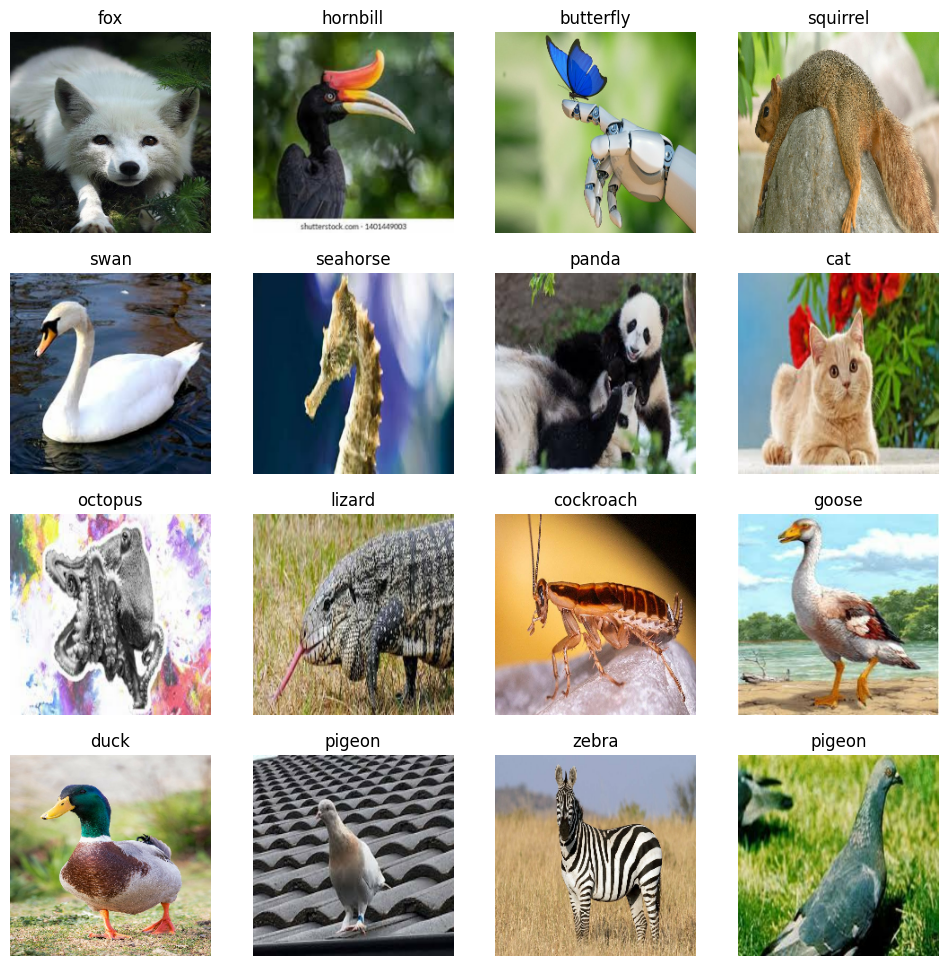

In [20]:
# Visualisation
# No matter how many times you run this cell, the images won't change.
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

### Performance Optimisation

Using `tf.data.AUTOTUNE` and the specific method below creates an asynchronous pipeline—basically, it allows the CPU to prepare the next batch while the GPU is still processing the current one.

In [21]:
# AUTOTUNE allows TensorFlow to dynamically adjust the resource allocation 
# (like CPU threads) based on your hardware's current workload at runtime.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    # Keep the data in memory (RAM) after the first epoch.
    # This prevents the CPU from having to re-read and re-decode JPEGs 
    # from the slow hard drive during every subsequent training round.
    .cache()

    # Maintain a buffer of 1,000 samples and randomly pulls from it.
    # This ensures the model doesn't learn the order of the files, 
    # but rather the features of the images.
    .shuffle(1000)

    # Overlaps the data preprocessing and model execution.
    # While the GPU is training on the current batch, the CPU is already 
    # preparing the next batch in the background. This eliminates "GPU starvation."
    .prefetch(buffer_size=AUTOTUNE)
)

In [22]:
validation_dataset = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Data Augmentation (Modern Keras Layers)

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

###  A more modern CNN architecture (Vanilla CNN)

In [24]:
def build_cnn_model(input_shape, num_classes):

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1.0/255)(x)

    # ConvNet Block 1
    x = tf.keras.layers.Conv2D(32, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 2
    x = tf.keras.layers.Conv2D(64, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 3
    x = tf.keras.layers.Conv2D(128, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 4
    x = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # Classifier
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Outputs
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Build model
    model = tf.keras.Model(inputs, outputs)

    return model

### Build and Compile the Model

In [25]:
# Build the model

model = build_cnn_model(
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,),
    num_classes=number_classes
)

In [26]:
# Verify model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 568,090 (2.17 MB)

 Trainable params: 567,130 (2.16 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
# Compile the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Configure Callbacks

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/best_animal_cnn.keras",
    monitor="val_accuracy",
    save_best_only=True,
    # verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1
)


callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]

### Train the model to learn patterns from the images

In [29]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1766743508.049314     139 cuda_dnn.cc:529] Loaded cuDNN version 91002


19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.0227 - loss: 4.5347 - val_accuracy: 0.0222 - val_loss: 4.4914 - learning_rate: 0.0010
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 987ms/step - accuracy: 0.0679 - loss: 4.1583 - val_accuracy: 0.0130 - val_loss: 4.5261 - learning_rate: 0.0010
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0793 - loss: 3.9801 - val_accuracy: 0.0148 - val_loss: 4.6234 - learning_rate: 0.0010
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1027 - loss: 3.8726 - val_accuracy: 0.0148 - val_loss: 4.7301 - learning_rate: 0.0010
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1131 - loss: 3.7960 - val_accuracy: 0.0130 - val_loss: 4.8650 - learning_rate: 0.0010
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1204 - loss: 3.6869
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1206 - loss: 3.6863 - val_accuracy: 0.013

### Plot Training Curves (Learning Dynamics)

In [30]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


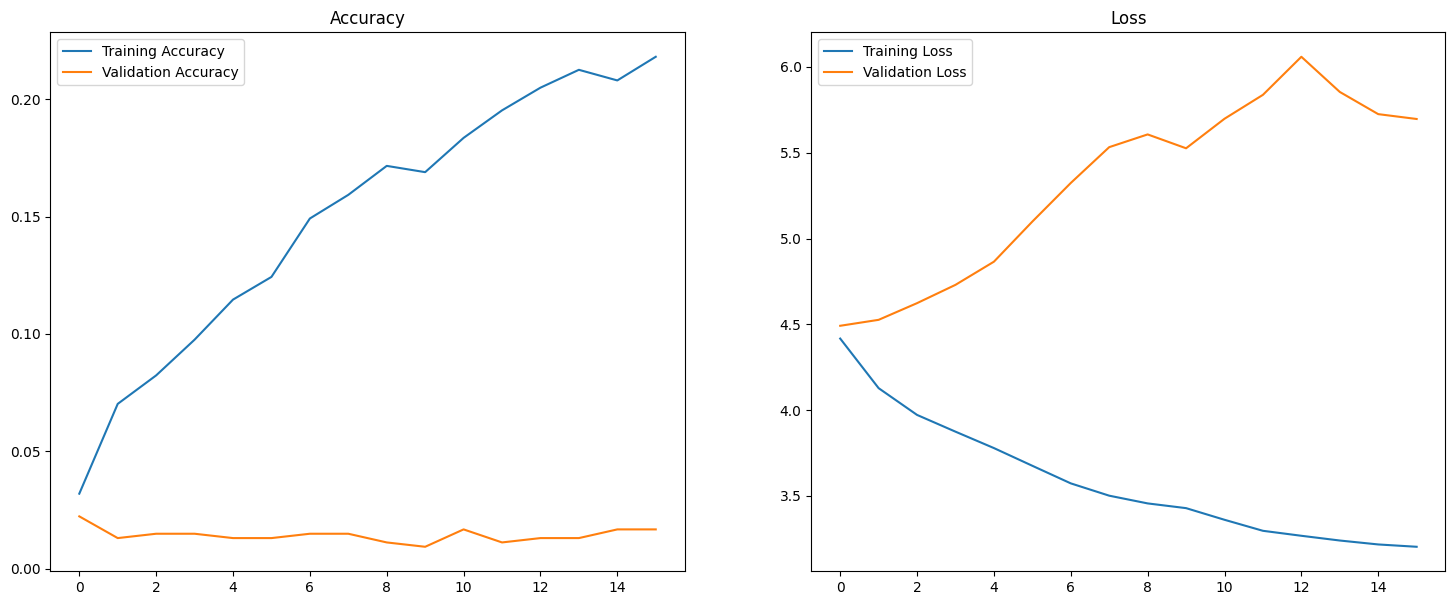

In [31]:
plot_learning_curves(history)

### Generate Predictions (TensorFlow to NumPy)

In [32]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0204 - loss: 4.4921
Model Loss: 4.49
Model Accuracy: 0.02


In [33]:
y_true = []
y_pred = []
y_prob = []

for images, labels in validation_dataset:
    preds = model.predict(images, verbose=1) # Try verbose=0
    y_prob.append(preds)
    y_pred.append(np.argmax(preds, axis=1))
    y_true.append(labels.numpy())

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


In [34]:
len(y_true), len(y_pred), len(y_prob)

(3, 3, 3)

In [35]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

### Core Classification Metrics (from scikit-learn)

In [36]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)



print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.2f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average="macro"):.2f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average="macro"):.2f}")

Accuracy: 0.02
Precision (macro): 0.00
Recall (macro): 0.02
F1-score (macro): 0.01


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
# Full Classification Report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


                precision    recall  f1-score   support

      antelope     0.0000    0.0000    0.0000         3
        badger     0.0000    0.0000    0.0000         5
           bat     0.0000    0.0000    0.0000         7
          bear     0.0000    0.0000    0.0000         7
           bee     0.0000    0.0000    0.0000         3
        beetle     0.0000    0.0000    0.0000         3
         bison     0.0000    0.0000    0.0000         5
          boar     0.0000    0.0000    0.0000         2
     butterfly     0.0000    0.0000    0.0000         6
           cat     0.0000    0.0000    0.0000         7
   caterpillar     0.0000    0.0000    0.0000         8
    chimpanzee     0.0000    0.0000    0.0000         6
     cockroach     0.0286    0.1429    0.0476         7
           cow     0.0000    0.0000    0.0000         5
        coyote     0.0000    0.0000    0.0000         9
          crab     0.0000    0.0000    0.0000         4
          crow     0.0000    0.0000    0.0000  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# plt.figure(figsize=(14, 12))
# sns.heatmap(cm_norm, cmap="Blues", cbar=False, annot=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.title("Confusion Matrix (Normalized)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45, ha="right")
# plt.show()

In [39]:
# ROC–AUC (One-vs-Rest, Multi-Class)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true_bin = label_binarize(y_true, 
                            classes=range(number_classes))

roc_auc_macro = roc_auc_score(
    y_true_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)

roc_auc_weighted = roc_auc_score(
    y_true_bin,
    y_prob,
    average="weighted",
    multi_class="ovr"
)

print("ROC-AUC (macro):", roc_auc_macro)
print("ROC-AUC (weighted):", roc_auc_weighted)


ROC-AUC (macro): 0.5958818877741617
ROC-AUC (weighted): 0.608947821752484


In [40]:
# Precision–Recall AUC (PR-AUC)

from sklearn.metrics import average_precision_score

pr_auc_macro = average_precision_score(
    y_true_bin,
    y_prob,
    average="macro"
)

pr_auc_weighted = average_precision_score(
    y_true_bin,
    y_prob,
    average="weighted"
)

print("PR-AUC (macro):", pr_auc_macro)
print("PR-AUC (weighted):", pr_auc_weighted)

PR-AUC (macro): 0.035826240375214355
PR-AUC (weighted): 0.043803996855194365


In [41]:
# Top-K Accuracy (Important for 90 Classes)

top_5_acc = tf.keras.metrics.top_k_categorical_accuracy(
    y_true_bin,
    y_prob,
    k=5
).numpy().mean()

print("Top-5 Accuracy:", top_5_acc)


Top-5 Accuracy: 0.08888889


In [42]:
# TensorFlow Native Metrics

tf_acc = tf.keras.metrics.SparseCategoricalAccuracy()
tf_acc.update_state(y_true, y_prob)
print("TF Accuracy:", tf_acc.result().numpy())

TF Accuracy: 0.022222223


In [43]:
# Saving the Model

model.save("animals_224x224_final.keras")

**This resulted in a poor model. We will use transfer learning to see how to improve the model using any of the model which is already doing well in general image processing tasks.**